# 3D Plotting Termination Sets

Illustrate the termination sets for the digging model in a rotatable 3D plot.

In [1]:
%matplotlib notebook

In [2]:
cd ../tests

/Users/mitchallain/Development/Python/BeagleBone-excavator/tests


In [3]:
ls

BBB_predictor_test.py   encoder_test.py         prediction_test.pyc
PID.py                  encoder_test_simple.py  sg_model.py
PID.pyc                 end_pts.pkl             sg_model.pyc
autonomous.py           exc.mat                 sg_model_1022.py
autonomous_endpts.py    excavator.py            sg_model_1101.py
autonomous_task.pkl     excavator.pyc           sg_model_1101.pyc
blended.py              manual.py               steps.py
blended_old.py          model_gen.py            trajectories.py
calibrate.py            point_measurement.py    trajectories.pyc
data/                   prediction_test.py      ziegler_nichols.py


In [4]:
from sg_model_1101 import sg_model
from trajectories import forward_kin_v
import numpy as np

## Termination sets in actuator space

Create vectors with subgoal ranges in each dimension of actuator space.

In [5]:
# Set the mesh size along each actuator
mesh_dim = 5

In [6]:
sg_space = []

for sg in sg_model:
    sg_act_space = []
    for i in range(4):
        sg_act_space.append(np.linspace(sg['subgoal_pos'][i]-sg['npt'][i],
                                        sg['subgoal_pos'][i]+sg['npt'][i],
                                        mesh_dim))
    sg_space.append(sg_act_space)
    
print(sg_act_space)

[array([  9.239,   9.739,  10.239,  10.739,  11.239]), array([  7.89,   8.54,   9.19,   9.84,  10.49]), array([ 1.398,  1.998,  2.598,  3.198,  3.798]), array([-0.087, -0.037,  0.013,  0.063,  0.113])]


## Meshing

Mesh each subgoal in actuator space using numpy.meshgrid

In [7]:
meshes = []
for sg in sg_space:
    x1, x2, x3, x4 = np.meshgrid(sg[0], sg[1], sg[2], sg[3])
    meshes.append([x1, x2, x3, x4])

## Vectorize the forward kinematics

Import the trajectories module and vectorize the forward_kin function with numpy.vectorize.

In [8]:
import mat4py
temp = mat4py.loadmat('exc.mat')
exc = temp['exc']

help(forward_kin_v)

Help on function forward_kin_v in module trajectories:

forward_kin_v(exc, sw, bm, sk, bk)
    This func is the same as 'forward_kin' in this module but is easily vectorized.
    
    Note: ported to Python from MATLAB "fwd_kin.m", assumed options = [0, 0]
    
    Args:
        exc (dict): a dict of the excavator physical parameters
        sw (float): the swing angle
        bm (floats): boom displacement in cm
        sk      ^^
        bk      ^^
    
    Returns:
        eef (list: float): the position of the end-effector (EEF) in (x, y, z - base frame) and the angle of the bucket (axis x4 w.r.t. x1(0?) ground axis)



In [9]:
forward_kin_vec = np.vectorize(forward_kin_v)

## Compute the end-effector positions for each subgoal

Run the forward_kin function on every meshed subgoal region and plot the points.

In [10]:
sg_eef = []
for sg in meshes:
    sg_eef.append(forward_kin_vec(exc, sg[3], sg[0], sg[1], sg[2]))
# sg_eef[0]

In [11]:
# Collapse meshed output arrays into plottable vectors, x, y, z
sg_eef_flat = []

for sg in sg_eef:
    x = sg[0].flatten()
    y = sg[1].flatten()
    z = sg[2].flatten()
    sg_eef_flat.append([x, y, z])

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt

In [13]:
labels = ['SG '+str(i+1) for i in range(5)]
labels

['SG 1', 'SG 2', 'SG 3', 'SG 4', 'SG 5']

In [14]:
cd ../ipython\ notebooks

/Users/mitchallain/Development/Python/BeagleBone-excavator/ipython notebooks


<IPython.core.display.Javascript object>


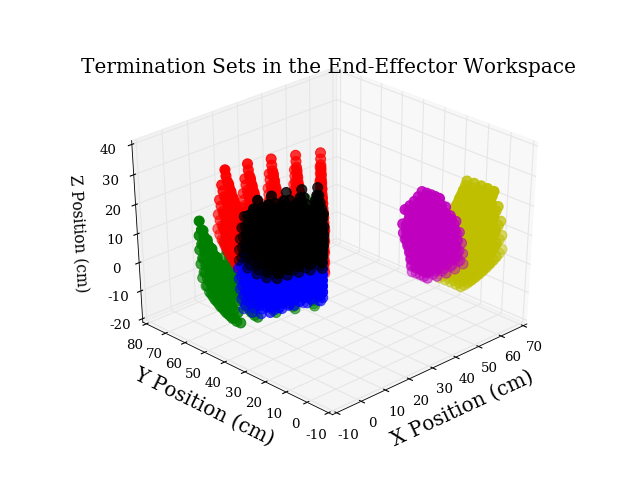

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')

labels = ['SG '+str(i+1) for i in range(6)]
# x = np.linspace(0, 1, 100)
# y = np.sin(x * 2 * np.pi) / 2 + 0.5
# ax.plot(x, y, zs=0, zdir='z', label='zs=0, zdir=z')
colors = ('r', 'g', 'b', 'k', 'm', 'y')
for i, sg in enumerate(sg_eef_flat):
    ax.scatter(sg[0], sg[1], sg[2], zdir='z', c=colors[i],
               s=80, edgecolors='face', label=labels[i])
#     ax.legend()


plt.title('Termination Sets in the End-Effector Workspace', family='serif', fontsize=18)
plt.xlabel('X Position (cm)', family='serif', labelpad=10, fontsize=18)
plt.ylabel('Y Position (cm)', family='serif', labelpad=10, fontsize=18)
ax.set_xticklabels(range(-10, 80, 10), family='serif')
ax.set_yticklabels(range(-10, 90, 10), family='serif')
ax.set_zticklabels(range(-20, 50, 10), family='serif')
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)
# plt.zlabel('z Position (cm)')
ax.view_init(azim=-142, elev=17)
plt.tight_layout
plt.show()

plt.savefig('termination_sets.png',dpi=600)